# Final Project - Classification

### 90-803 Machine Learning Foundations with Python (Spring 2023)
#### Team: Team 6 / M'N'M
#### Name: Niharika Patil, Marisa Yang, Madi Zhaksylyk

### Classify the playing position of football players based on performance metrics, market value and demographics.

Target Variable: Playing position a football (soccer) player based on performance metrices (minutes played, goals scored, assists, red and yellow cards, etc.), their current market value and their personal demographic statictics (age, height).

##### Author: Niharika Patil (niharikp)

In [68]:
#Import necessary libraries

import pandas as pd
import numpy as np
import datetime as datetime
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures,RobustScaler, StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score,GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics,preprocessing, neighbors, tree
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, r2_score, mean_squared_error
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from imblearn.pipeline import Pipeline as imb_pipe
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from yellowbrick.target import ClassBalance
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')



In [2]:
#Read the dataset
data_df = pd.read_csv('data/all_merged.csv')
data_df.tail()

,player_id,player_club_id,year,goals,assists,yellow_cards,red_cards,minutes_played,games_played,league_rank,...,assists_per_90,yellows_per_90,reds_per_90,minutes_per_game,country_of_citizenship,country_of_birth,position,foot,height_in_cm,age
44737,914562,273,2022,3,0,5,0,570,16,5.0,...,0.000000,0.789474,0.000000,35.625000,France,France,Attack,Right,181.0,17
44738,939763,7378,2022,2,1,3,0,885,13,6.0,...,0.101695,0.305085,0.000000,68.076923,Brazil,Brazil,Attack,Left,185.0,23
44739,946883,366,2022,0,0,0,0,602,8,2.0,...,0.000000,0.000000,0.000000,75.250000,Spain,Spain,Defender,Right,182.0,18
44740,962555,2282,2022,1,0,6,1,1106,14,9.0,...,0.000000,0.488246,0.081374,79.000000,Cote d'Ivoire,Cote d'Ivoire,Defender,Left,188.0,20
44741,980576,1420,2022,3,1,0,0,619,14,5.0,...,0.145396,0.000000,0.000000,44.214286,France,France,Attack,Right,192.0,22


In [3]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44742 entries, 0 to 44741
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   player_id               44742 non-null  int64  
 1   player_club_id          44742 non-null  int64  
 2   year                    44742 non-null  int64  
 3   goals                   44742 non-null  int64  
 4   assists                 44742 non-null  int64  
 5   yellow_cards            44742 non-null  int64  
 6   red_cards               44742 non-null  int64  
 7   minutes_played          44742 non-null  int64  
 8   games_played            44742 non-null  int64  
 9   league_rank             44742 non-null  float64
 10  adjusted_price          44742 non-null  float64
 11  CL_minutes_played       44742 non-null  int64  
 12  CL_games_played         44742 non-null  int64  
 13  EL_minutes_played       44742 non-null  int64  
 14  EL_games_played         44742 non-null

### Feature Engineering

Intuitively, the columns player_id, player_club_id, year, country of citizenship and country of birth seems irrelavent to the classification problem. It can be dropped from the dataframe.

In [4]:
#Drop unnecessary columns
data_df = data_df.drop(['player_id', 'player_club_id', 'year', 'country_of_citizenship', 'country_of_birth'], axis = 1)
data_df.head()

,goals,assists,yellow_cards,red_cards,minutes_played,games_played,league_rank,adjusted_price,CL_minutes_played,CL_games_played,...,EL_games_played,goals_per_90,assists_per_90,yellows_per_90,reds_per_90,minutes_per_game,position,foot,height_in_cm,age
0,4,3,2,0,496,15,3.0,1.235231e+06,0,0,...,0,0.725806,0.544355,0.362903,0.0,33.066667,Attack,Right,184.0,36
1,12,8,6,0,2429,36,3.0,1.230897e+06,0,0,...,1,0.444627,0.296418,0.222314,0.0,67.472222,Attack,Right,184.0,37
2,8,5,1,0,1078,20,3.0,1.219360e+06,0,0,...,3,0.667904,0.417440,0.083488,0.0,53.900000,Attack,Right,184.0,38
3,2,2,1,0,679,15,1.0,2.428327e+06,8,1,...,0,0.265096,0.265096,0.132548,0.0,45.266667,Attack,Both,179.0,35
4,5,1,0,0,985,13,2.0,2.472417e+06,0,0,...,0,0.456853,0.091371,0.000000,0.0,75.769231,Attack,Right,193.0,33


The column foot is categorical data and hence needs to be encoded. We will use one hot encoding for this.

In [5]:
#Encode the column foot using one hot encoding
enc = pd.get_dummies(data_df['foot'])

#merge the enc data with dataframe
data_df = pd.concat([data_df, enc], axis = 1)

#Drop the original foot column
data_df.drop('foot', axis = 1, inplace = True)

data_df

,goals,assists,yellow_cards,red_cards,minutes_played,games_played,league_rank,adjusted_price,CL_minutes_played,CL_games_played,...,assists_per_90,yellows_per_90,reds_per_90,minutes_per_game,position,height_in_cm,age,Both,Left,Right
0,4,3,2,0,496,15,3.0,1.235231e+06,0,0,...,0.544355,0.362903,0.000000,33.066667,Attack,184.0,36,0,0,1
1,12,8,6,0,2429,36,3.0,1.230897e+06,0,0,...,0.296418,0.222314,0.000000,67.472222,Attack,184.0,37,0,0,1
2,8,5,1,0,1078,20,3.0,1.219360e+06,0,0,...,0.417440,0.083488,0.000000,53.900000,Attack,184.0,38,0,0,1
3,2,2,1,0,679,15,1.0,2.428327e+06,8,1,...,0.265096,0.132548,0.000000,45.266667,Attack,179.0,35,1,0,0
4,5,1,0,0,985,13,2.0,2.472417e+06,0,0,...,0.091371,0.000000,0.000000,75.769231,Attack,193.0,33,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44737,3,0,5,0,570,16,5.0,7.437500e+06,0,0,...,0.000000,0.789474,0.000000,35.625000,Attack,181.0,17,0,0,1
44738,2,1,3,0,885,13,6.0,4.076923e+05,0,0,...,0.101695,0.305085,0.000000,68.076923,Attack,185.0,23,0,1,0
44739,0,0,0,0,602,8,2.0,1.000000e+06,0,0,...,0.000000,0.000000,0.000000,75.250000,Defender,182.0,18,0,0,1
44740,1,0,6,1,1106,14,9.0,4.085714e+06,405,5,...,0.000000,0.488246,0.081374,79.000000,Defender,188.0,20,0,1,0


In [6]:
#Instantiate LabelEncoder
le = LabelEncoder()

#fit and transform target variable
data_df['position_enc'] = le.fit_transform(data_df['position'])

data_df

,goals,assists,yellow_cards,red_cards,minutes_played,games_played,league_rank,adjusted_price,CL_minutes_played,CL_games_played,...,yellows_per_90,reds_per_90,minutes_per_game,position,height_in_cm,age,Both,Left,Right,position_enc
0,4,3,2,0,496,15,3.0,1.235231e+06,0,0,...,0.362903,0.000000,33.066667,Attack,184.0,36,0,0,1,0
1,12,8,6,0,2429,36,3.0,1.230897e+06,0,0,...,0.222314,0.000000,67.472222,Attack,184.0,37,0,0,1,0
2,8,5,1,0,1078,20,3.0,1.219360e+06,0,0,...,0.083488,0.000000,53.900000,Attack,184.0,38,0,0,1,0
3,2,2,1,0,679,15,1.0,2.428327e+06,8,1,...,0.132548,0.000000,45.266667,Attack,179.0,35,1,0,0,0
4,5,1,0,0,985,13,2.0,2.472417e+06,0,0,...,0.000000,0.000000,75.769231,Attack,193.0,33,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44737,3,0,5,0,570,16,5.0,7.437500e+06,0,0,...,0.789474,0.000000,35.625000,Attack,181.0,17,0,0,1,0
44738,2,1,3,0,885,13,6.0,4.076923e+05,0,0,...,0.305085,0.000000,68.076923,Attack,185.0,23,0,1,0,0
44739,0,0,0,0,602,8,2.0,1.000000e+06,0,0,...,0.000000,0.000000,75.250000,Defender,182.0,18,0,0,1,1
44740,1,0,6,1,1106,14,9.0,4.085714e+06,405,5,...,0.488246,0.081374,79.000000,Defender,188.0,20,0,1,0,1


In [7]:
data_df['position'].unique()

array(['Attack', 'Midfield', 'Defender'], dtype=object)

In [8]:
#Seperate target and features
y = data_df['position_enc']
X = data_df.drop(['position', 'position_enc'], axis = 1)
y

0        0
1        0
2        0
3        0
4        0
        ..
44737    0
44738    0
44739    1
44740    1
44741    0
Name: position_enc, Length: 44742, dtype: int64

In [9]:
data_df.describe()

,goals,assists,yellow_cards,red_cards,minutes_played,games_played,league_rank,adjusted_price,CL_minutes_played,CL_games_played,...,assists_per_90,yellows_per_90,reds_per_90,minutes_per_game,height_in_cm,age,Both,Left,Right,position_enc
count,44742.000000,44742.000000,44742.000000,44742.000000,44742.000000,44742.000000,44742.000000,4.474200e+04,44742.000000,44742.000000,...,44742.000000,44742.000000,44742.000000,44742.000000,44742.000000,44742.000000,44742.000000,44742.000000,44742.000000,44742.000000
mean,2.224778,1.687385,3.267243,0.074069,1440.493876,20.018528,7.439453,6.276993e+06,38.294175,0.546086,...,0.100872,0.212482,0.005093,71.325427,181.648120,26.491574,0.042399,0.252537,0.705065,0.903312
std,3.572744,2.357370,2.705077,0.274390,803.577089,9.592590,5.154001,1.223515e+07,129.548378,1.731634,...,0.118226,0.152982,0.021502,15.094949,6.357122,4.054413,0.201499,0.434472,0.456019,0.770128
min,0.000000,0.000000,0.000000,0.000000,451.000000,5.000000,1.000000,2.826918e+04,0.000000,0.000000,...,0.000000,0.000000,0.000000,16.333333,151.525773,16.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,817.000000,13.000000,3.000000,7.410883e+05,0.000000,0.000000,...,0.000000,0.106509,0.000000,61.166667,177.000000,23.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,3.000000,0.000000,1236.000000,17.000000,6.000000,2.036002e+06,0.000000,0.000000,...,0.069930,0.188416,0.000000,74.769231,182.000000,26.000000,0.000000,0.000000,1.000000,1.000000
75%,3.000000,2.000000,5.000000,0.000000,1837.750000,26.000000,11.000000,6.052798e+06,0.000000,0.000000,...,0.159645,0.298599,0.000000,84.000000,186.000000,29.000000,0.000000,1.000000,1.000000,2.000000
max,58.000000,32.000000,23.000000,3.000000,5070.000000,59.000000,20.000000,2.301768e+08,1230.000000,13.000000,...,1.187335,1.319218,0.361446,98.571429,202.000000,44.000000,1.000000,1.000000,1.000000,2.000000


In [10]:
#Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
y_test

43624    0
12535    0
21149    1
26843    1
18906    2
        ..
30299    0
14266    0
10901    2
44541    2
42387    0
Name: position_enc, Length: 8949, dtype: int64

Since this is a classification problem, it is necessary to check for class imbalance and take the necessary steps.

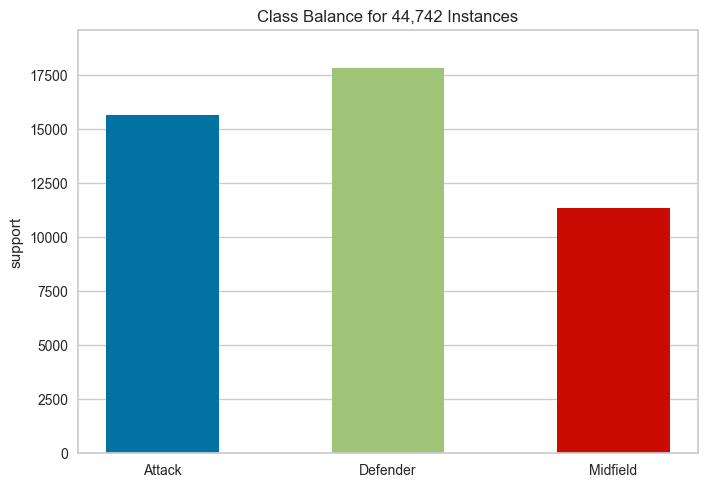

<AxesSubplot: title={'center': 'Class Balance for 44,742 Instances'}, ylabel='support'>

In [11]:
#Check for class imbalance
#Define the labels
labels=['Attack', 'Defender', 'Midfield']

#initialize ClassBalance
visualizer = ClassBalance(labels = labels)

#Train with column data
visualizer.fit(data_df['position_enc'])
visualizer.show()   

As can be seen from the visualization, there is an imbalance in number of instances for each of the classes but there is no clear domination of one class over the other. While balancing the classes could help, we can include it in the pipeling while fitting the model to see if that would be necessary.

### 1. KNN Classifier

Due to imbalance in classes before scaling, check which train datasets work best with the classifier.

In [12]:
#Trying knn with default settings to check the fit of train data sets
print("------- Unsampled Train Data ---------\n")
knn = KNeighborsClassifier().fit(X_train, y_train)
print('Training set score: %.3f' % knn.score(X_train, y_train))
print('Test set score: %.3f' % knn.score(X_test, y_test))

------- Unsampled Train Data ---------

Training set score: 0.576
Test set score: 0.385


 With default settings, knn with default setting does a poor job of classifying. The model needs to be hyperparameter tuned. We will use a pipeline for the same.

In [13]:
#Instantiate KNN Pipeline
knn_pipe = imb_pipe([('smt', SMOTE()), ('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_jobs = -1))])

In [26]:
#Defining parameter for hyper parameter tuning
parameters = {'smt' : [None, SMOTE(), RandomOverSampler(sampling_strategy = 'not majority'), RandomUnderSampler(sampling_strategy = 'not minority')],
     'scaler': [None, RobustScaler(), StandardScaler(), MinMaxScaler(), MaxAbsScaler()],
     'knn__n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10],
     'knn__algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']
}

In [27]:
#Perform Grid seach cv using the above defined pipeline and hyper parameters
grid = GridSearchCV(knn_pipe, parameters, cv=10).fit(X_train, y_train)
 
#Print best model accuracy
print('Training accuracy: %.3f' % grid.score(X_train, y_train))
print('Test accuracy: %.3f' % grid.score(X_test, y_test))

Training accuracy: 0.741
Test accuracy: 0.681


In [28]:
#Print the combination of the best parameters
grid.best_params_

{'knn__algorithm': 'auto',
 'knn__n_neighbors': 10,
 'scaler': StandardScaler(),
 'smt': None}

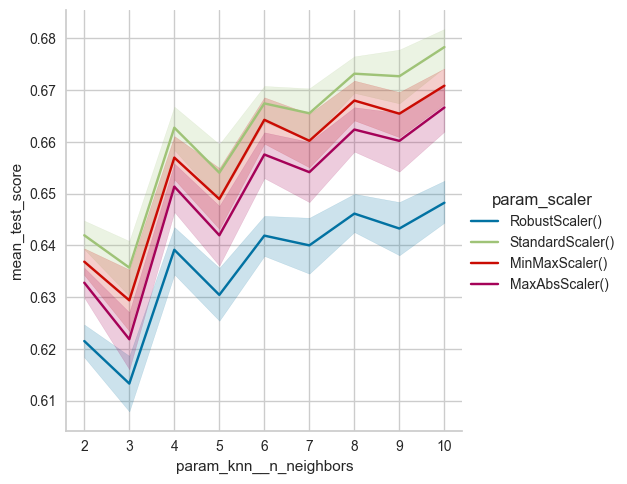

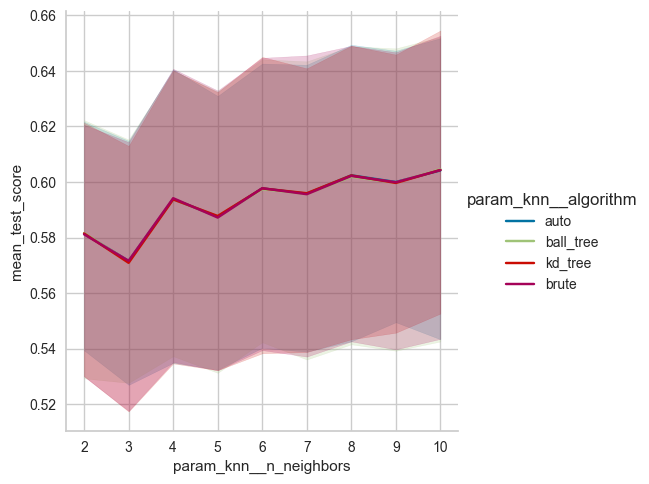

In [29]:
#convert the results of gridsearch cv to dataframe
result_knn = pd.DataFrame.from_dict(grid.cv_results_, orient='columns')

#Plot the results of varying scaler methods and algorithms against different n-neighbors 
#fig, (ax1, ax2) = plt.subplots(1,2)
sns.relplot(data = result_knn, kind = 'line',
 x = 'param_knn__n_neighbors',
 y = 'mean_test_score',
 hue = 'param_scaler')

sns.relplot(data = result_knn, kind = 'line',
 x = 'param_knn__n_neighbors',
 y = 'mean_test_score',
 hue = 'param_knn__algorithm')

plt.show()

knn model with 10 neighbors and fit on standard scaled data gives the best results of 69% test accuracy, which is much better than the default model. The best model can be fit, to get a closer look at its performance through classification reports and confusion matrix.

Training set score: 0.741
Test set score: 0.680

 Classification Report:
              precision    recall  f1-score   support

      Attack       0.75      0.82      0.78      3117
    Defender       0.68      0.82      0.75      3524
    Midfield       0.49      0.28      0.36      2308

    accuracy                           0.68      8949
   macro avg       0.64      0.64      0.63      8949
weighted avg       0.66      0.68      0.66      8949


 Confusion Matrix:


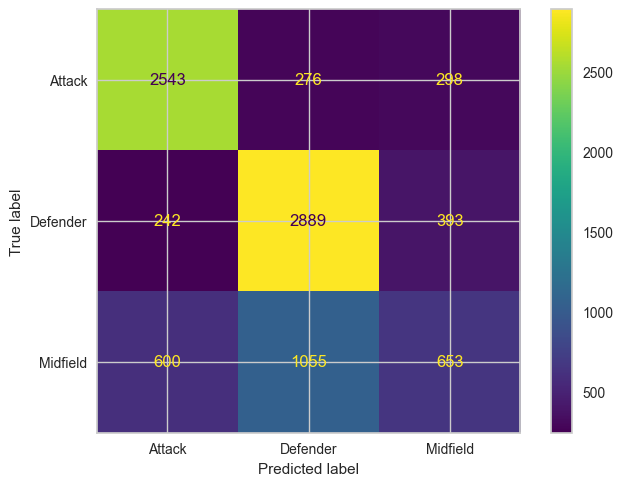

In [31]:
#Scale and fit the model with best parameter obtained from hyperparameter tuning using the pipeling 
knn_pipe = imb_pipe([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_neighbors = 10, n_jobs = -1))])
knn_pipe.fit(X_train_scaled, y_train)
y_pred_knn = knn_pipe.predict(X_test_scaled)

print('Training set score: %.3f' % knn_best.score(X_train_scaled, y_train))
print('Test set score: %.3f' % knn_best.score(X_test_scaled, y_test))

#Defining labels
labels=['Attack', 'Defender', 'Midfield']

#Preparing the consuion matrix with the actual and predicted values
cm = confusion_matrix(y_test, y_pred_knn)

#Print Classification Report
print('\n Classification Report:')
print(classification_report(y_test, y_pred_knn, target_names = labels))

#Display Confusion Matrix
print('\n Confusion Matrix:')
disp = ConfusionMatrixDisplay(cm, display_labels = labels)
disp.plot()
plt.show()

The above confusion matrix shows that the model has a harder time classifying 'midfield'. Balancing the classes doesn't seem to fix the issue as it might be not as issue arising from class imbalance. Other models need to be checked for better performances. 

### 2. Logistic Regression

The next model our team chose is the linear regression model. Will fit data with default settings to get a better understanding of the performance of model with out data. 

In [32]:
#Trying knn with default settings to check the fit of train data sets
print("------- Unsampled Train Data ---------\n")
lr = LogisticRegression(max_iter=5000).fit(X_train, y_train)
print('Training set score: %.3f' % knn.score(X_train, y_train))
print('Test set score: %.3f' % knn.score(X_test, y_test))

------- Unsampled Train Data ---------

Training set score: 0.576
Test set score: 0.385


 With default settings, unbalanced and unsampled train data performs better with test data whereas SMOTE train data has a better train data performance. However, knn with default setting does a poor job of classifying. The model needs to be hyperparameter tuned. We will use a pipeline for the same.

In [38]:
#Instantiate pipeline
lr_pipe = Pipeline([('lr', LogisticRegression(max_iter=1000))])

In [39]:
#Defining parameter for hyper parameter tuning
parameters = {'lr__solver' : ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
        'lr__class_weight' : [None, 'balanced']
}

In [41]:
#Perform Grid seach cv using the above defined pipeline and hyper parameters
grid = GridSearchCV(lr_pipe, parameters, cv=10).fit(X_train, y_train)
 
print('Training accuracy: %.3f' % grid.score(X_train, y_train))
print('Test accuracy: %.3f' % grid.score(X_test, y_test))

Training accuracy: 0.703
Test accuracy: 0.701


In [42]:
#Print the combination of the best parameters
grid.best_params_

{'lr__class_weight': None, 'lr__solver': 'newton-cg'}

Logistic Regression model with newton-cg solver and without any class weights gives the test accuracy of 71.4%, which is much better than the default model and the best fit knn model. The best model should be trained to get a closer look at its performance through classification reports and confusion matrix.

Training set score: 0.703
Test set score: 0.701

 Classification Report:
              precision    recall  f1-score   support

      Attack       0.78      0.83      0.80      3117
    Defender       0.69      0.86      0.77      3524
    Midfield       0.53      0.28      0.37      2308

    accuracy                           0.70      8949
   macro avg       0.67      0.66      0.65      8949
weighted avg       0.68      0.70      0.68      8949


 Confusion Matrix:


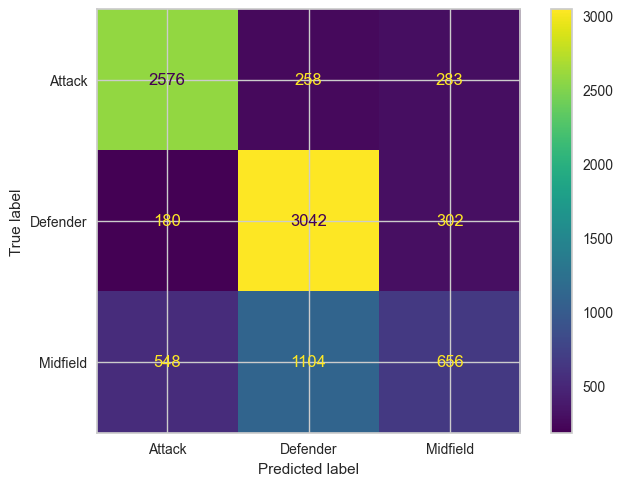

In [43]:
#Fit the model with best parameter obtained from hyperparameter tuning
lr_best = LogisticRegression(max_iter = 50000, solver = 'newton-cg')
lr_best.fit(X_train, y_train)
y_pred_lr = lr_best.predict(X_test)

print('Training set score: %.3f' % lr_best.score(X_train, y_train))
print('Test set score: %.3f' % lr_best.score(X_test, y_test))

#Defining labels
labels=['Attack', 'Defender', 'Midfield']

#Preparing the consuion matrix with the actual and predicted values
cm = confusion_matrix(y_test, y_pred_lr)

#Print Classification Report
print('\n Classification Report:')
print(classification_report(y_test, y_pred_lr, target_names = labels))

#Display Confusion Matrix
print('\n Confusion Matrix:')
disp = ConfusionMatrixDisplay(cm, display_labels = labels)
disp.plot()
plt.show()

The above confusion matrix shows that the model has a harder time classifying 'midfield', just like the knn classifier. Balancing the classes doesn't seem to fix the issue either. This could be an issue with the data itself. Other models need to be checked for better performances. 

### 3. Decision Tree Classifier

In [44]:
#Initialize Decision Tree Classifier 
dtc = DecisionTreeClassifier()
#Train the model
dtc.fit(X_train, y_train)

#Train accuracy
print("Train accuracy:", dtc.score(X_train, y_train))

# Test accuracy
print("Test accuracy:", dtc.score(X_test, y_test))


Train accuracy: 1.0
Test accuracy: 0.616158229969829


The decision tree model is clearly overfitting for the data and not doing very well on the test dataset. The model needs to hyper parameter tuned to improve accuracy and hence performance. A grid search cv would help with this. 

In [52]:
#Instantiate pipeline
dt_pipe = imb_pipe([('smt', SMOTE()), ('scaler', StandardScaler()), ('dt', DecisionTreeClassifier())])

In [53]:
#Defining parameter for hyper parameter tuning
parameters = {'smt': [None, SMOTE(), RandomOverSampler(sampling_strategy = 'not majority'), RandomUnderSampler(sampling_strategy = 'not minority')],
    'scaler': [RobustScaler(), StandardScaler(), MinMaxScaler(), MaxAbsScaler()],
    'dt__criterion' : ["gini", "entropy", "log_loss"],
    'dt__max_depth': [10, 15, 20, 25, 50],
    'dt__max_features': ["auto", "sqrt", "log2"]
}

In [54]:
#Perform Grid seach cv using the above defined pipeline and hyper parameters
grid = GridSearchCV(dt_pipe, parameters, cv=10).fit(X_train, y_train)
 
print('Training accuracy: %.3f' % grid.score(X_train, y_train))
print('Test accuracy: %.3f' % grid.score(X_test, y_test))

Training accuracy: 0.710
Test accuracy: 0.669


In [55]:
grid.best_params_

{'dt__criterion': 'entropy',
 'dt__max_depth': 10,
 'dt__max_features': 'log2',
 'scaler': RobustScaler(),
 'smt': None}

Now that we have the best params, we can fit the best model for a closer look into performance of the model.

Training set score: 0.705
Test set score: 0.662

 Classification Report:
              precision    recall  f1-score   support

      Attack       0.74      0.80      0.77      3117
    Defender       0.67      0.79      0.72      3524
    Midfield       0.47      0.28      0.35      2308

    accuracy                           0.66      8949
   macro avg       0.62      0.62      0.61      8949
weighted avg       0.64      0.66      0.64      8949


 Confusion Matrix:


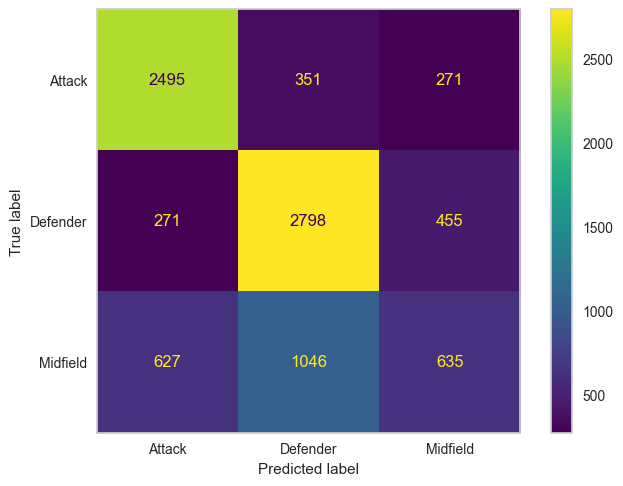

In [56]:
 #Training the best fit model

#Train the model using the pipeline
dt_pipe_best = imb_pipe([('scaler', RobustScaler()), 
                    ('dt', DecisionTreeClassifier(class_weight = None, criterion = 'gini' , max_features = 'auto', max_depth = 10))
                        ])

dt_pipe_best.fit(X_train, y_train)

y_pred_dt = dt_pipe_best.predict(X_test)

print('Training set score: %.3f' % dt_pipe_best.score(X_train, y_train))
print('Test set score: %.3f' % dt_pipe_best.score(X_test, y_test))

#Defining labels
labels=['Attack', 'Defender', 'Midfield']

#Preparing the consuion matrix with the actual and predicted values
cm = confusion_matrix(y_test, y_pred_dt)

#Print Classification Report
print('\n Classification Report:')
print(classification_report(y_test, y_pred_dt, target_names = labels))

#Display Confusion Matrix
print('\n Confusion Matrix:')
disp = ConfusionMatrixDisplay(cm, display_labels = labels)
disp.plot()
plt.grid(False)
plt.show()


This model comparitively does a better job of classfying midefielders than the previous two models, but the over all accuracy and precision is low. This might be because the model is prone to variance. Ensemble learning methods like Random Forrest might be able to overcome this issue and improve the results.

### 4. Random Forrest

The idea is to improve on the decision tree by introducing random forrest.

In [58]:
#Initialize RandomForestClassifier model with default settings
rfc = RandomForestClassifier(class_weight = None, criterion = 'log_loss' , max_features = 'auto', max_depth = 12)

#Train the model with smote as decision tree's hyper parameter tuning suggested that 
#decision trees perform better with smote sampled data
rfc.fit(X_train, y_train)

#Print performance
print(f"Train accuracy: {rfc.score(X_train, y_train)}")
print(f"Test accuracy: {rfc.score(X_test, y_test)}")

Train accuracy: 0.8175620931467047
Test accuracy: 0.7139345178232205


While the train accuracy is good, we will see if we can improve it by gyper parameter tuning.

In [65]:
#Instantiate pipeline
rf_pipe = imb_pipe([('scaler', StandardScaler()), ('rf', RandomForestClassifier(criterion = 'log_loss'))])

In [66]:
#Defining parameter for hyper parameter tuning
parameters = {'scaler': [None, RobustScaler(), StandardScaler()],
    'rf__max_depth': [9,10,11,12,13],
    'rf__n_estimators' : [50,75,125,150,200,250,300]
}


In [67]:
#Perform Grid seach cv using the above defined pipeline and hyper parameters
grid = GridSearchCV(rf_pipe, parameters, cv=10).fit(X_train, y_train)
 
print('Training accuracy: %.3f' % grid.score(X_train, y_train))
print('Test accuracy: %.3f' % grid.score(X_test, y_test))

Training accuracy: 0.850
Test accuracy: 0.714


The test accuracy increased very slightly whereas the train accuracy increased significantly. Time to take a closer look into the model by best fitting it.

In [ ]:
grid.best_params_

In [ ]:
#Initialize RandomForestClassifier model
rfc_best = RandomForestClassifier(class_weight = None, criterion = 'log_loss' , max_features = 'auto', max_depth = 12)

#Train the model with smote as decision tree's hyper parameter tuning suggested that 
#decision trees perform better with smote sampled data
rfc_best.fit(X_train, y_train)

y_pred_rf = rfc_best.predict(X_test)

print('Training set score: %.3f' % rfc_best.score(X_train, y_train))
print('Test set score: %.3f' % rfc_best.score(X_test, y_test))

#Defining labels
labels=['Attack', 'Defender', 'Midfield']

#Preparing the consuion matrix with the actual and predicted values
cm = confusion_matrix(y_test, y_pred_rf)

#Print Classification Report
print('\n Classification Report:')
print(classification_report(y_test, y_pred_rf, target_names = labels))

#Display Confusion Matrix
print('\n Confusion Matrix:')
disp = ConfusionMatrixDisplay(cm, display_labels = labels)
disp.plot()
plt.grid(False)
plt.show()


### 5. Support Vector Machine

In [22]:
svc = SVC()
svc.fit(X_train, y_train)

#Print performance
print(f"Train accuracy: {svc.score(X_train, y_train)}")
print(f"Test accuracy: {svc.score(X_test, y_test)}")

Train accuracy: 0.42108792221942837
Test accuracy: 0.41837076768354003


In [23]:
svc.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [70]:
#Defining parameter for hyper parameter tuning
parameters = {'degree' : [1,2,3,4,5],
             'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}


In [ ]:
#Perform Grid seach cv using the above defined pipeline and hyper parameters
svc = SVC()
grid = RandomizedSearchCV(svc, param_distributions = parameters, n_iter = 100, cv = 5, random_state=42).fit(X_train, y_train)

print('Training accuracy: %.3f' % grid.score(X_train, y_train))
print('Test accuracy: %.3f' % grid.score(X_test, y_test))

#### References:
1. https://www.kaggle.com/code/kauvinlucas/xgboost-imblearn-pipeline-for-classification
2. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
3. https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
4. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
5. https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
6. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
7. https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
8. https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/